# Test set evaluation of Gender image classification models

## UTKFace dataset

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
# UTKFace image directories (unsorted and sorted)
TEST_DIR = 'UTKFace/'
TEST_SORT_DIR = 'UTKFace sorted/'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [5]:
# Move UTKFace images into unique directories based on their gender label
# Need only to run once to organize
# m_dir = 'UTKFace sorted/male'
# f_dir = 'UTKFace sorted/female'

# import shutil

# for filename in os.listdir(TEST_DIR):
#     image_path = os.path.join(TEST_DIR, filename)
#     temp = filename.split('_')
#     gender = int(temp[1])
#     if gender == 0:                                # Move to Male folder
#         new_path = os.path.join(m_dir, filename)
#         shutil.move(image_path, new_path)
#     elif gender == 1:                              # Move to Female folder
#         new_path = os.path.join(f_dir, filename)
#         shutil.move(image_path, new_path)

## Load images

### a. image_dataset_from_directory
### image_size = (224, 224)

In [6]:
# Grayscale test set images
test_ds_gs = tf.keras.utils.image_dataset_from_directory(TEST_SORT_DIR, 
                                                         seed=123, 
                                                         batch_size=128,
                                                         image_size=(224, 224),
                                                         color_mode="grayscale")
# RGB test set images
test_ds_rgb = tf.keras.utils.image_dataset_from_directory(TEST_SORT_DIR, 
                                                         seed=123, 
                                                         batch_size=128,
                                                         image_size=(224, 224),
                                                         color_mode="rgb")

# one-hot encoding
one_hot_gs = test_ds_gs.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
one_hot_rgb = test_ds_rgb.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

Found 23708 files belonging to 2 classes.
Found 23708 files belonging to 2 classes.


In [7]:
test_labels = np.concatenate([y for x, y in test_ds_gs], axis=0)

In [8]:
# Prediction function
def reload_predict(model, dataset):
    # Reload model from saved .h5 files
    model.summary()
    test_ds = dataset
    # make predictions on test set images
    test_predictions = model.predict(test_ds)
    # Evaluate the model
    test_predictions_rounded_labels=np.argmax(test_predictions, axis=1)
    print(classification_report(test_labels, test_predictions_rounded_labels))
    cm = confusion_matrix(test_labels, test_predictions_rounded_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(accuracy_score(test_labels, test_predictions_rounded_labels))

In [9]:
test_labels

array([1, 1, 0, ..., 1, 0, 0], dtype=int32)

## Evaluate models

### VGG-16 Model 1a-gs: Grayscale + Frozen Layers

### VGG-16 Model 1b-gs: Grayscale + Frozen layers

In [10]:
# Recreate model instance
M1b_gs = keras.models.load_model('GC weights/Frozen/mod1b-gs/mod1b_gs_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,576
Trainable params: 2,032
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 33s 137ms/step
              precision    recall  f1-score   support

           0       0.48      0.37      0.42     11317
        

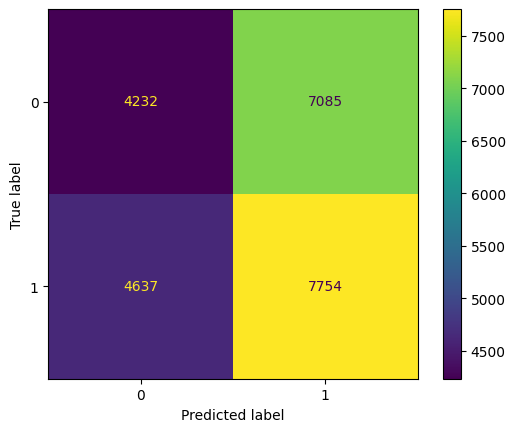

0.5055677408469715


In [11]:
reload_predict(M1b_gs, one_hot_gs)

### VGG-16 Model 1a-RGB: RGB + Frozen layers

### VGG-16 Model 1b-RGB: RGB + Frozen layers

In [12]:
# Recreate model instance
M1b_rgb = keras.models.load_model('GC weights/Frozen/mod1b-RGB/mod1b_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,546
Trainable params: 2,002
Non-trainable params: 138,357,544
_________________________________________________________________
186/186 [==============================] - 34s 149ms/step
              precision    recall  f1-score   support

           0       0.47      0.43      0.45     11317
           1       0.52      0.57      0.54     12391

    accuracy                           0.50     23708
   macro avg       0.50      0.

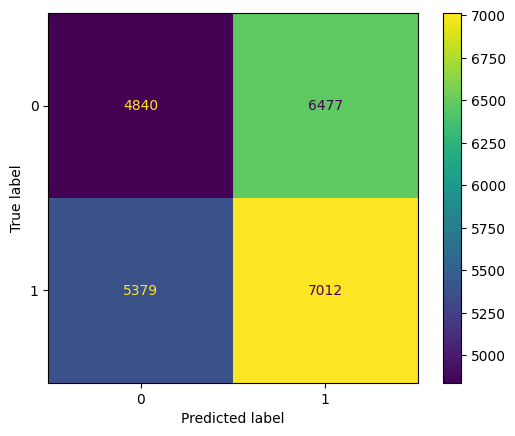

0.4999156402901974


In [13]:
reload_predict(M1b_rgb, one_hot_rgb)

### Basic CNN Model 2a-RGB: RGB + No frozen Layers

### Basic CNN Model 2b-RGB: RGB + No frozen Layers

In [14]:
# Recreate model instance
M2b_rgb = keras.models.load_model('GC weights/Unfrozen/mod2b-RGB/mod2b_RGB.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

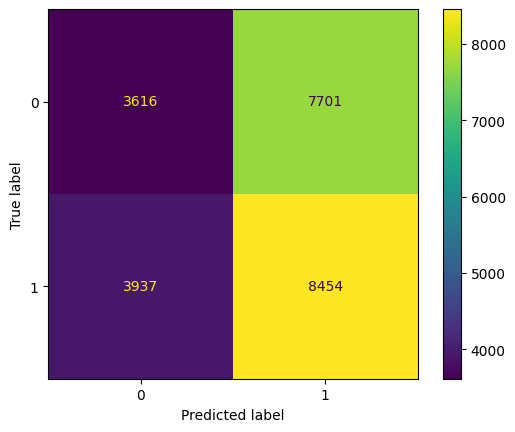

0.5091108486586806


In [15]:
reload_predict(M2b_rgb, one_hot_rgb)

### Basic CNN Model 2a-gs: Grayscale + No frozen Layers

### Basic CNN Model 2b-gs: Grayscale + No frozen Layers

In [16]:
# Recreate model instance
M2b_gs = keras.models.load_model('GC weights/Unfrozen/mod2b-gs/mod2b_gs.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  30          ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  896         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

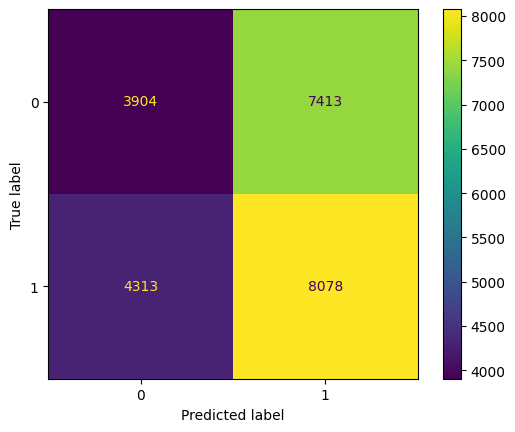

0.5053990214273663


In [17]:
reload_predict(M2b_gs, one_hot_gs)

### DenseNet201 Model 3a-RGB: RGB + Frozen Layers

### DenseNet201 Model 3b-RGB: RGB + Frozen Layers

In [18]:
# Recreate model instance
M3b_rgb = keras.models.load_model('GC weights/Frozen/mod3b-RGB/mod3b_RGB_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,244,986
Trainable params: 2,002
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 42s 207ms/step
              precision    recall  f1-score   support

           0       0.48      0.30      0.37     11317
           1       0.52      0.70      0.60     12391

    accuracy                           0.51     23708
   macro avg       0.50      0.50

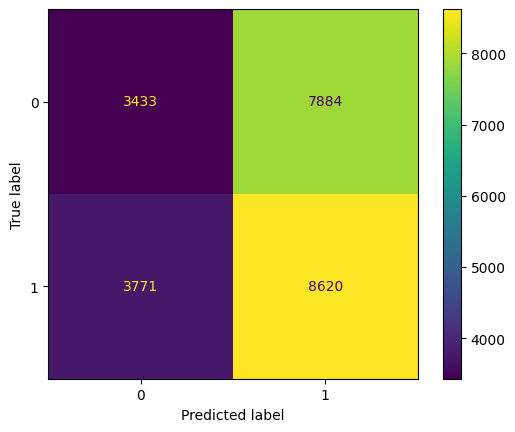

0.5083937911253585


In [19]:
reload_predict(M3b_rgb, one_hot_rgb)

### DenseNet201 Model 3a-gs: Grayscale + Frozen Layers

### DenseNet201 Model 3b-gs: Grayscale + Frozen Layers

In [20]:
# Recreate model instance
M3b_gs = keras.models.load_model('GC weights/Frozen/mod3b-gs/mod3b_gs_frozen.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 densenet201 (Functional)    (None, 1000)              20242984  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 20,245,016
Trainable params: 2,032
Non-trainable params: 20,242,984
_________________________________________________________________
186/186 [==============================] - 38s 196ms/step
              precision    recall  f1-score   support

           0       0.49      0.16      0.24     11317
          

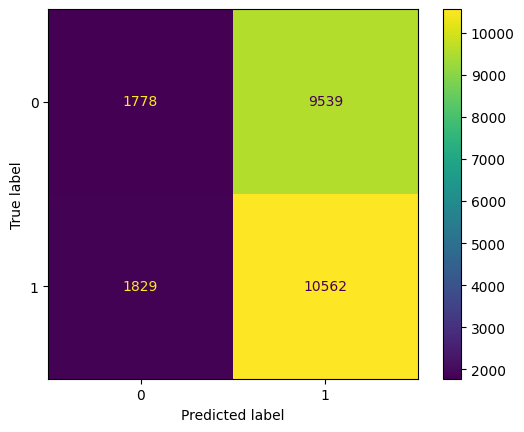

0.5204994094820313


In [21]:
reload_predict(M3b_gs, one_hot_gs)